In [52]:
# % matplotlib inline
import pandas as pd
import math
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from fbprophet import Prophet

In [2]:
training_data = pd.read_csv('../dataset/usage_train.csv', date_parser = pd.to_datetime)

split the data

In [3]:
training_data['datetime'] = pd.DatetimeIndex(training_data['datetime'])
training_data['weekofyear']= training_data.datetime.apply(lambda x: x.weekofyear)
training_data = training_data.rename(columns = {'datetime': 'ds','usage': 'y'})

In [57]:
n_index = training_data.ds.nunique()
idx_split = math.floor(n_index*0.99)
list_dates = list(training_data.ds.unique())
threshold = list_dates[idx_split]
print(threshold)

2013-12-06T19:00:00.000000000


In [58]:
threshold + np.timedelta64(7,'D')

numpy.datetime64('2013-12-13T19:00:00.000000000')

In [73]:
df_training = training_data[training_data.ds <= threshold]
df_test = training_data[(training_data.ds > threshold) & (training_data.ds <= threshold + np.timedelta64(7,'D'))]

In [74]:
df_training.id.unique()

array(['MAC003828', 'MAC003685', 'MAC005415', 'MAC000085', 'MAC004671',
       'MAC004218', 'MAC001757', 'MAC004166', 'MAC000246', 'MAC000094'],
      dtype=object)

#### Create model for a house

In [105]:
df_house = df_training[df_training.id == 'MAC005415']
df_house_test = df_test[df_test.id == 'MAC005415']

In [106]:
df_house.head(5)

,id,ds,y,weekofyear
34368,MAC005415,2012-12-17 09:00:00,0.018,51
34369,MAC005415,2012-12-17 09:30:00,0.119,51
34370,MAC005415,2012-12-17 10:00:00,0.110,51
34371,MAC005415,2012-12-17 10:30:00,0.054,51
34372,MAC005415,2012-12-17 11:00:00,0.079,51


In [107]:
model = Prophet(interval_width = 0.95)
model.fit(df_house[['ds','y']])

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


#### Predictions

In [108]:
future_dates = df_house_test[['ds']]

In [109]:
future_dates.ds.nunique()

171

In [110]:
future_dates = df_house_test[['ds']]
forecast = model.predict(future_dates)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
164,2013-12-10 05:30:00,0.080401,0.001094,0.153316
165,2013-12-10 06:00:00,0.087168,0.010910,0.158861
166,2013-12-10 06:30:00,0.093011,0.019270,0.167584
167,2013-12-10 07:00:00,0.097120,0.022844,0.172283
168,2013-12-10 07:30:00,0.098989,0.027612,0.175190
169,2013-12-10 08:00:00,0.098531,0.021210,0.169313
170,2013-12-10 08:30:00,0.096093,0.023202,0.173695


In [111]:
fc = forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

#### visualizing predictions

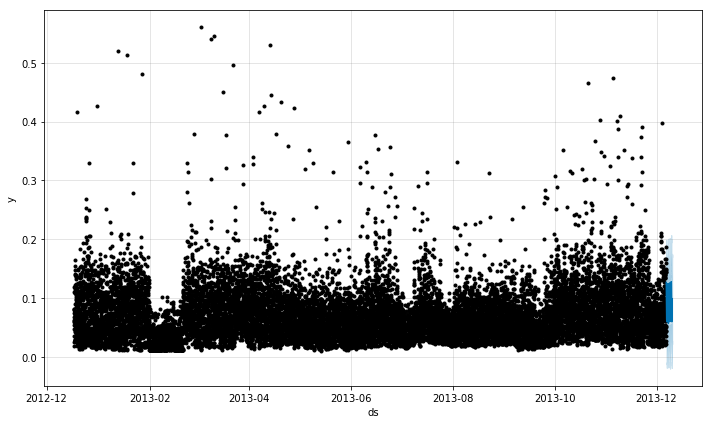

In [112]:
model.plot(forecast);

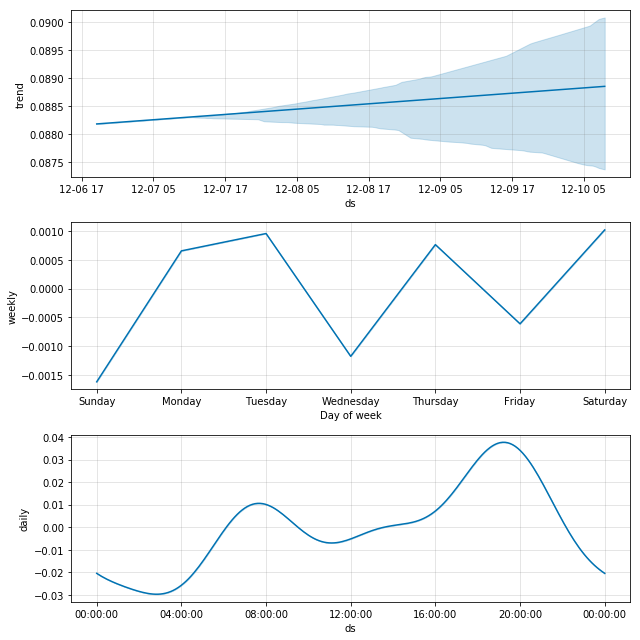

In [113]:
x = model.plot_components(forecast)

In [114]:
forecast[['ds', 'yhat']]
results = df_house_test[['ds', 'y']].merge(forecast[['ds', 'yhat']], on = 'ds')

In [115]:
results.head(5)

,ds,y,yhat
0,2013-12-06 19:30:00,0.143,0.126350
1,2013-12-06 20:00:00,0.156,0.123247
2,2013-12-06 20:30:00,0.119,0.117461
3,2013-12-06 21:00:00,0.108,0.109700
4,2013-12-06 21:30:00,0.149,0.100921


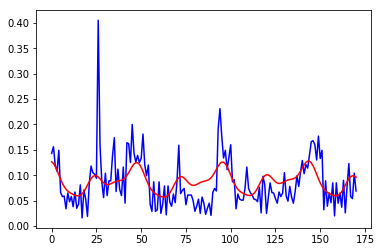

In [116]:
plt.figure()
x = plt.plot(results['y'], 'b')
x = plt.plot(results['yhat'], 'r')
plt.show()

In [117]:
np.sqrt(mean_squared_error(results['y'], results['yhat']))

0.04236598720094664